In [97]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from numba import njit, prange

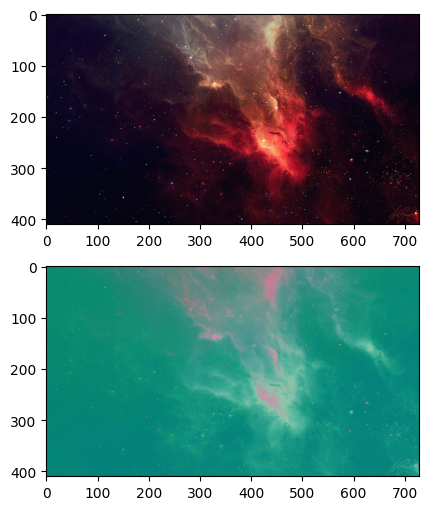

In [98]:
img_src = cv2.imread('./app-data/inputs/red-hibiscus.jpg')
img_lab= cv2.cvtColor(img_src, cv2.COLOR_BGR2LAB)
img_src = cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB)

plt.imshow(img_src)

In [99]:
# INPUT: desired superpixels count
K = 100
# INPUT: compactness of superpixel
m = 10 # can be in range [1, 20]

# img size
height, width = img_src.shape[0], img_src.shape[1] 
N = img_src.shape[0] * img_src.shape[1]

# superpix cnt
sp_cnt = N / K

# grid interval
S = int(np.sqrt(sp_cnt))


def d_lab(labxy: np.ndarray):
    return np.linalg.norm(labxy[:3])

def d_xy(labxy: np.ndarray):
    return np.linalg.norm(labxy[3:])

def Ds(first: np.ndarray, second: np.ndarray):
    diff = second - first
    return d_lab(diff) + (m / S) * d_xy(diff)

def squares_sum(vec: np.ndarray):
    return np.sum(vec**2)

def gradient(point: np.ndarray):
    y, x = point
    return (
            squares_sum(
                img_lab[y + 1, x] - img_lab[y - 1, x]
            )
            + squares_sum(
        img_lab[y, x + 1] - img_lab[y, x - 1]
    )
    )

### 1: Initialize cluster centers Ck = [lk, ak, bk, xk, yk]^T by sampling pixels at regular grid steps S.

In [100]:
Ck = []
grid_interval = int(S)
for row in range(grid_interval, height, grid_interval):
    for col in range(grid_interval, width, grid_interval):
        min_grad = np.inf
        min_grad_point = np.array([row, col])
        y_bounds = np.clip(np.array([row - 1, row + 1]), 0, height - 1)
        x_bounds = np.clip(np.array([col - 1, col + 1]), 0, width - 1)
        for dy in range(*y_bounds):
            for dx in range(*x_bounds):
                point = np.array([dy, dx])
                grad = gradient(point)
                if grad < min_grad:
                    min_grad = grad
                    min_grad_point = point
        labyx = np.array([*img_lab[*min_grad_point], *min_grad_point])
        Ck.append(labyx)

In [101]:
Ck

[array([  9, 139, 110,  53,  53]),
 array([ 11, 139, 110,  53, 107]),
 array([ 31, 133, 116,  54, 161]),
 array([ 45, 135, 121,  54, 215]),
 array([110, 135, 129,  54, 270]),
 array([ 94, 140, 134,  53, 323]),
 array([ 85, 147, 138,  53, 378]),
 array([162, 138, 148,  54, 432]),
 array([ 66, 147, 143,  53, 486]),
 array([ 50, 145, 132,  54, 540]),
 array([ 34, 146, 124,  54, 593]),
 array([ 23, 145, 119,  53, 647]),
 array([  9, 138, 118,  54, 701]),
 array([ 10, 139, 112, 108,  53]),
 array([ 14, 139, 114, 107, 107]),
 array([  5, 136, 121, 107, 161]),
 array([ 34, 139, 122, 108, 215]),
 array([ 48, 142, 124, 108, 269]),
 array([105, 145, 141, 107, 324]),
 array([117, 151, 145, 108, 377]),
 array([ 98, 157, 146, 107, 431]),
 array([ 43, 146, 131, 107, 486]),
 array([ 34, 150, 130, 107, 539]),
 array([ 27, 145, 125, 107, 593]),
 array([ 10, 138, 118, 107, 647]),
 array([ 10, 139, 120, 107, 701]),
 array([ 10, 138, 113, 161,  54]),
 array([ 10, 138, 112, 162, 107]),
 array([ 12, 143, 11

In [102]:
closest_cluster_for = np.full((height, width, 2), [-1, np.inf])
count = np.zeros((len(Ck)))

s2 = int(2*S)

def perturbate():
    # 1. Assign the best matching pixels from a 2S × 2S square neighborhood around the cluster center according to the distance measure
    for cluster_num, cluster_center in enumerate(Ck):
        _, _, _, y, x = cluster_center

        y_bounds = np.clip(np.array([y - s2, y + s2]), 0, height - 1)
        x_bounds = np.clip(np.array([x - s2, x + s2]), 0, width - 1)
        
        for dy in range(*y_bounds):
            for dx in range(*x_bounds):
                second_point = np.array([*img_lab[dy, dx], dy, dx])
                dist = Ds(cluster_center, second_point)
                if dist < closest_cluster_for[dy, dx, 1]:
                    closest_cluster_for[dy, dx] = (cluster_num, dist)
    
    # 2. Compute new cluster centers and residual error E {L1 distance between previous centers and recomputed centers}
    for cluster_num, cluster_center in enumerate(Ck):
        _, _, _, y, x = cluster_center
        min_grad = np.inf
        min_grad_point = np.array([row, col])
        
        y_bounds = np.clip(np.array([y - 1, y + 1]), 0, height - 1)
        x_bounds = np.clip(np.array([x - 1, x + 1]), 0, width - 1)
        
        for dy in range(*y_bounds):
            for dx in range(*x_bounds):
                point = np.array([dy, dx])
                grad = gradient(point)
                if grad < min_grad:
                    min_grad = grad
                    min_grad_point = point
        Ck[cluster_num][3:] = min_grad_point

In [103]:
for i in range(10):
    perturbate()

In [104]:
pixeledImg = img_src.copy()

for j in range(closest_cluster_for.shape[0] - 1):
    for i in range(closest_cluster_for.shape[1] - 1):
        if(
            closest_cluster_for[j, i, 0] != closest_cluster_for[j, i + 1, 0]
                or
                closest_cluster_for[j, i, 0] != closest_cluster_for[j + 1, i, 0]
        ):
            pixeledImg[j, i] = (0, 0, 0)

<Figure size 1920x1440 with 0 Axes>

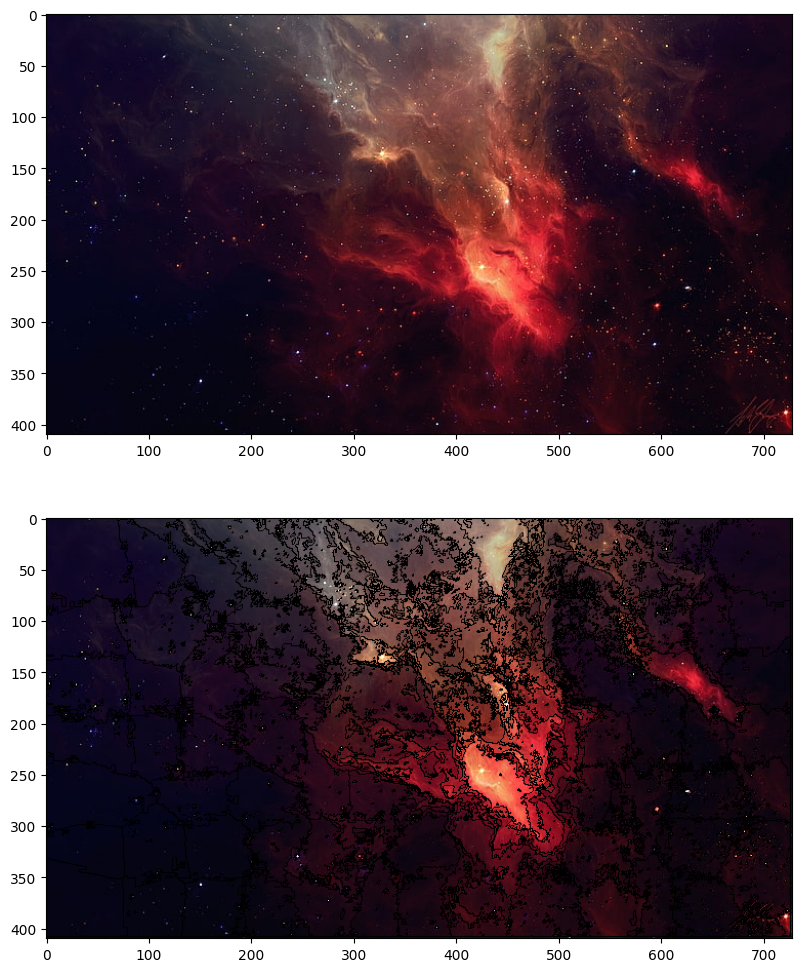

In [110]:
plt.figure().set_dpi(300)
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].imshow(img_src)
ax[1].imshow(pixeledImg)